In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import umodel as unf

import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

In [28]:
# Loading data cos(n, -)
with open('../data/CosThetaNminus/asimov_spinCorrelation.json', 'r') as read_file:
    dm = np.array(json.load(read_file))
    
with open('../data/CosThetaNminus/resmat_spinCorrelation.json', 'r') as read_file:
    rm = np.array(json.load(read_file))

    
# Loading data cos(n, +)
with open('../data/CosThetaNplus/asimov_spinCorrelation.json', 'r') as read_file:
    dp = np.array(json.load(read_file))
    
with open('../data/CosThetaNplus/resmat_spinCorrelation.json', 'r') as read_file:
    rp = np.array(json.load(read_file))

    
# Loading data correlations between the two observables
with open('../data/correlation_matrix_CosThetaNplus_CosThetaNminus_bins.json', 'r') as read_file:
    corrDict = json.load(read_file)

In [29]:
n, p = rm.shape[0], rp.shape[0]
corr = np.zeros((n+p, n+p))
for i, (iName, line) in enumerate(corrDict.items()):
    for j, (jName, c) in enumerate(line.items()):
        corr[i, j] = c

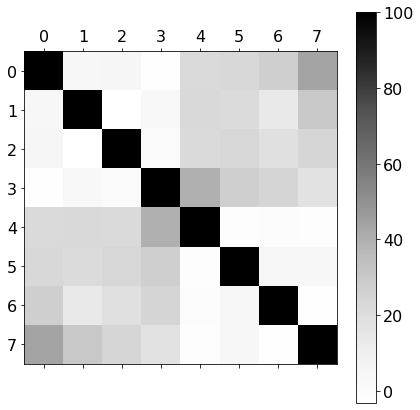

In [30]:
plt.matshow(corr*100, cmap='Greys')
plt.colorbar();

In [32]:
# With correlation
mCorr = unf.model(d1=dp, d2=dm, r1=rp, r2=rm, corr=corr)
bpCorr, bmCorr, _ = mCorr.unfold()
POIsCorr = mCorr.postFitUncerPOIs()

In [33]:
# Without correlations
m = unf.model(d1=dp, d2=dm, r1=rp, r2=rm, corr=np.diag([1]*8))
bp, bm, _ = m.unfold()
POIs = m.postFitUncerPOIs()

In [34]:
# Comparing result w/ and w/o corr from direct unfolding (full minimzation, only central values)
# --> no differences
print((bpCorr-bp)/bp)
print((bmCorr-bm)/bm)

[ 2.99907431e-16  4.51432779e-16 -3.00980962e-16  0.00000000e+00]
[ 1.50032122e-16  3.00819984e-16  4.51348482e-16 -1.49990672e-16]


In [35]:
# Comparing results w/ and w/o corr from profile LH
# --> differences from ~1% to 20% level!
relDiff = (POIsCorr-POIs) / POIs[:, 0, np.newaxis]
print( relDiff[:, 0] )

[-0.03602522 -0.00060042 -0.00060042 -0.03422396 -0.00060042 -0.19573702
 -0.00060042 -0.00060042]


In [36]:
# Comparing results between unfolded and profile, w/o corr
# --> no differences
for m1, m2 in zip(POIs, np.concatenate([bp, bm])):
    print((m1[0] - m2)/m1[0])

0.00030021014710291316
0.0003002101471030125
0.0003002101471029002
0.00030021014710301225
0.0003002101471030713
0.0003002101471030011
0.00030021014710294194
0.00030021014710291804


In [39]:
# Comparing results between unfolded and profiled, w/ corr
# --> large differences (from ~3% to 25%)!
for m1, m2 in zip(POIsCorr, np.concatenate([bpCorr, bmCorr])):
    print((m1[0] - m2)/m1[0])

-0.03706010588601684
-0.0003003905076599983
-0.00030039050765988607
-0.035125893689773126
-0.0003003905076599071
-0.24300111982082875
-0.00030039050765992765
-0.00030039050765990385


# WHY ??

 + check by hand the profile for `bm[1]` bin and compare with the full minimum